In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import argparse
import torch
import json
from collections import defaultdict

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from diffmask.models.question_answering_squad_diffmask import (
    BertQuestionAnsweringSquadDiffMask,
)
from diffmask.utils.plot import plot_squad_attributions, print_attributions

In [3]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--gpus", type=str, default="0")
    parser.add_argument("--model", type=str, default="bert-large-uncased-whole-word-masking-finetuned-squad")
    parser.add_argument(
        "--train_filename",
        type=str,
        default="./datasets/squad/train-v1.1_bert-large-uncased-whole-word-masking-finetuned-squad.json",
    )
    parser.add_argument(
        "--val_filename",
        type=str,
        default="./datasets/squad/dev-v1.1_bert-large-uncased-whole-word-masking-finetuned-squad.json",
    )
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--gate_bias", action="store_true")
    parser.add_argument("--seed", type=float, default=0)
    parser.add_argument(
        "--model_path",
        type=str,
        default="models/squad-diffmask-input.ckpt",
#         or
#         default="models/squad-diffmask-hidden.ckpt",
    )

    hparams, _ = parser.parse_known_args()
    
    torch.manual_seed(hparams.seed)
    
    os.environ["CUDA_VISIBLE_DEVICES"] = hparams.gpus

# Loading a model

In [4]:
device = "cuda:0"
model = BertQuestionAnsweringSquadDiffMask.load_from_checkpoint(hparams.model_path).to(device)
model.freeze()

# Creating and plotting DiffMask attributions

In [5]:
question = "Where did the Broncos practice for the Super Bowl ?"
context = """The Panthers used the San Jose State practice facility and \
stayed at the San Jose Marriott . The Broncos practiced at Stanford University \
and stayed at the Santa Clara Marriott ."""

inputs_dict = {
    k: v.to(device)
    for k, v in model.tokenizer.encode_plus(
        question,
        context,
        max_length=384,
        pad_to_max_length=True,
        return_tensors="pt",
    ).items()
}
inputs_dict["mask"] = inputs_dict["attention_mask"]
del inputs_dict["attention_mask"]

question = model.tokenizer.tokenize(question)
context = model.tokenizer.tokenize(context)
tokens = ["[CLS]"]  + question + ["[SEP]"]  + context + ["[SEP]"]

In [6]:
logits_start_orig, logits_end_orig, expected_L0_full = model.forward_explainer(
    **inputs_dict, attribution=True
)
attributions = expected_L0_full.exp()[0,:len(tokens)].cpu()

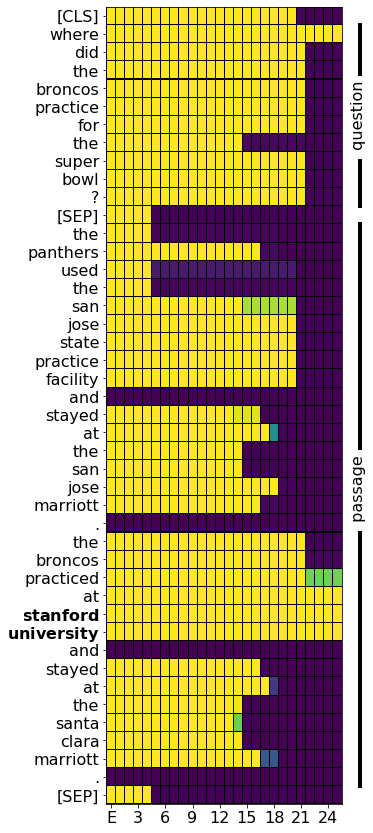

In [7]:
plot_squad_attributions(attributions, tokens, context, question, inputs_dict, logits_start_orig, logits_end_orig)

In [8]:
print_attributions(tokens, attributions.sum(-1))

[CLS] where did the broncos practice for the super bowl ? [SEP] the panthers used the san jose state practice facility and stayed at the san jose marriott . the broncos practiced at stanford university and stayed at the santa clara marriott . [SEP]


# Computing statistics on the validation set

In [9]:
with open(
    "./datasets/squad/dev-v1.1_bert-large-uncased-whole-word-masking-finetuned-squad-mapping.json", "r"
) as f:
    model.val_dataset_orig_offsets = json.load(f)
    
model.prepare_data()

In [10]:
val_dataset_orig = [e for e in model.val_dataset_orig.items()]
for i, batch in tqdm(enumerate(model.val_dataloader()), total=len(model.val_dataset) // model.hparams.batch_size):
    input_ids, mask, token_type_ids, _, _ = tuple(e.to(device) for e in batch)

    logits_start, logits_end, expected_L0_full = model.forward_explainer(
        input_ids, mask, token_type_ids, attribution=True
    )
    attributions = expected_L0_full.exp().cpu()

    for j in range(attributions.shape[0]):
        question_offset = len(val_dataset_orig[i * model.hparams.batch_size + j][1]["question"])
        val_dataset_orig[i * model.hparams.batch_size + j][1]["question"] = (
            val_dataset_orig[i * model.hparams.batch_size + j][1]["question"],
            attributions[j, 1:1 + question_offset]
        )

        val_dataset_orig[i * model.hparams.batch_size + j][1]["context"] = (
            val_dataset_orig[i * model.hparams.batch_size + j][1]["context"],
            attributions[j, 2 + question_offset:mask[j].sum().item() - 1]
        )
        
        val_dataset_orig[i * model.hparams.batch_size + j][1]["answer_model"] = [
            logits_start[j].argmax(-1).item() - question_offset - 2,
            logits_end[j].argmax(-1).item() - question_offset - 2,
        ]
        val_dataset_orig[i * model.hparams.batch_size + j][1]["special"] = attributions[
            j, [0, 1 + question_offset, mask[j].sum().item() - 1]
        ]
        
val_dataset_orig = dict(val_dataset_orig)

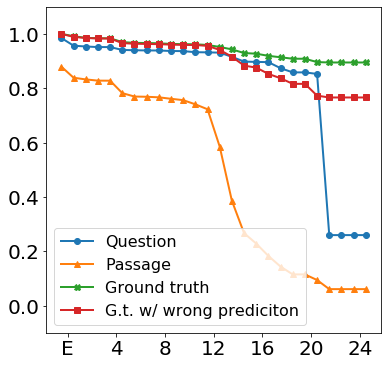

In [11]:
question_use = torch.stack([v["question"][1].mean(0) for k, v in val_dataset_orig.items()]).mean(0)
context_use = torch.stack([v["context"][1].mean(0) for k, v in val_dataset_orig.items()]).mean(0)
answer_model_use = torch.stack([
    (v["context"][1][v["answer_model"][0]] + v["context"][1][v["answer_model"][1]]) / 2
    for k, v in val_dataset_orig.items()
]).mean(0)

answer_correct_use = [[(v["context"][1][s] + v["context"][1][e]) / 2
               for s, e in v["answer_offsets"]]
              for k, v in val_dataset_orig.items()]
answer_correct_use = torch.stack([torch.stack(e).max(0).values for e in answer_correct_use]).mean(0)

answer_wrong_use = [[(v["context"][1][s] + v["context"][1][e]) / 2
               for s, e in v["answer_offsets"]]
              for k, v in val_dataset_orig.items() if v["answer_model"] not in v["answer_offsets"]]
answer_wrong_use = torch.stack([torch.stack(e).max(0).values for e in answer_wrong_use]).mean(0)

fig = plt.figure(figsize=(6, 6))

plt.plot(question_use, marker="o", linewidth=2, label="Question")
plt.plot(context_use, marker="^", linewidth=2, label="Passage")
plt.plot(answer_correct_use, marker="X", linewidth=2, label="Ground truth")
plt.plot(answer_wrong_use, marker="s", linewidth=2, label="G.t. w/ wrong prediciton")

plt.xticks(torch.arange(0, 25, 4) + .5, ["E"] + list(range(4, 25, 4)), size=20)
plt.yticks(torch.linspace(0, 1, 6), ["{:.1f}".format(e) for e in torch.linspace(0, 1, 6)], size=20)

plt.ylim(-0.1, 1.1)
plt.legend(fontsize=16, loc="lower left") #, frameon=False)
plt.show()


question


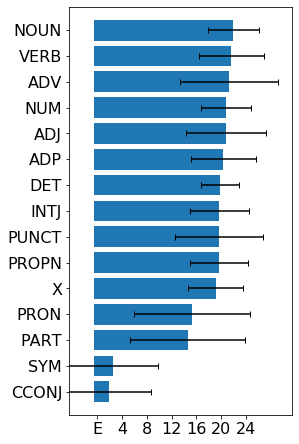

context


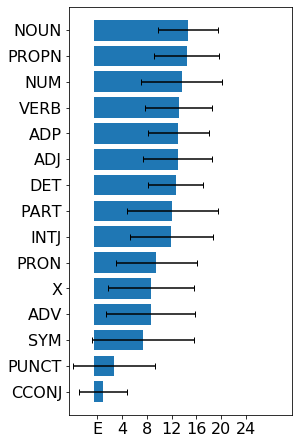

all


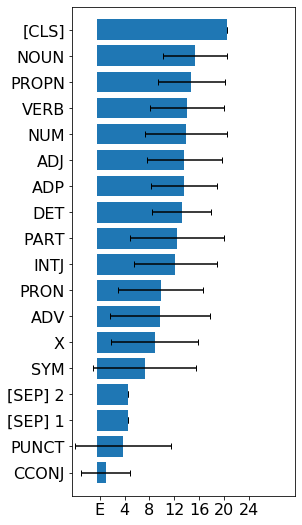

In [12]:
counts = {
    k: defaultdict(list) for k in ("question", "context", "all")
}
for k, v in tqdm(model.val_dataset_orig_offsets.items()):
    if k in val_dataset_orig:
        e = val_dataset_orig[k]
        for g in ("question", "context"):
            for f, s in zip([f[2] for f in v[g]], e[g][-1].sum(-1)):
                counts[g][f].append(s)
                counts["all"][f].append(s)
        counts["all"]["[CLS]"].append(e["special"][0].sum(-1))
        counts["all"]["[SEP] 1"].append(e["special"][1].sum(-1))
        counts["all"]["[SEP] 2"].append(e["special"][2].sum(-1))
                
for g in ("question", "context", "all"):
    print(g)
    
    counts[g] = sorted([(k, torch.stack(v)) for k, v in counts[g].items()])
    counts[g] = [(k, (v.mean(), v.std())) for k, v in counts[g]]
    counts[g] = sorted(counts[g], key=lambda x: x[1][0])

    fig = plt.figure(figsize=(4, len(counts[g]) / 2))
    plt.barh(range(len(counts[g])),
            [m.item() for k, (m, s) in counts[g]],
            xerr=[s.item() for k, (m, s) in counts[g]],
            capsize=3)
    plt.yticks(torch.arange(len(counts[g])), [k for k, (m, s) in counts[g]], size=16)
    plt.xticks(torch.arange(0, 25, 4) + .5, ["E"] + list(range(4, 25, 4)), size=16)
    
    plt.xlim(-4, 32)
    plt.margins(y=.5 / len(counts[g]))

    plt.show()


question


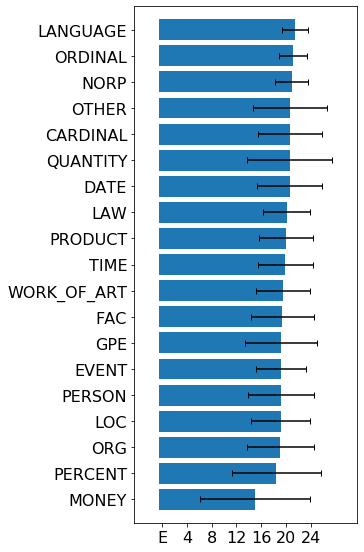

context


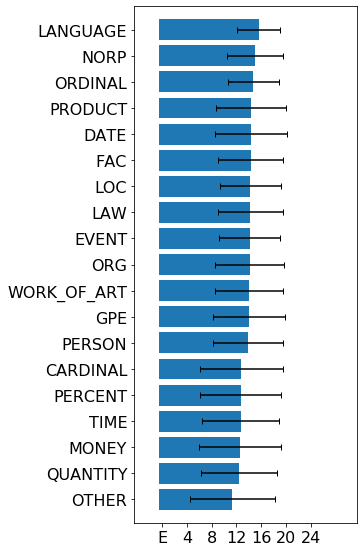

In [13]:
counts = {
    k: defaultdict(list) for k in ("question", "context")
}
for k, v in tqdm(model.val_dataset_orig_offsets.items()):
    if k in val_dataset_orig:
        e = val_dataset_orig[k]
        for g in ("question", "context"):
            for f, s in zip([f[-1] if len(f) == 7 else "OTHER" for f in v[g]], e[g][-1].sum(-1)):
                counts[g][f].append(s)
                
for g in ("question", "context"):
    print(g)
    
    counts[g] = sorted([(k, torch.stack(v)) for k, v in counts[g].items()])
    counts[g] = [(k, (v.mean(), v.std())) for k, v in counts[g]]
    counts[g] = sorted(counts[g], key=lambda x: x[1][0])
    
    fig = plt.figure(figsize=(4, len(counts[g]) / 2))
    plt.barh(range(len(counts[g])),
            [m.item() for k, (m, s) in counts[g]],
            xerr=[s.item() for k, (m, s) in counts[g]],
            capsize=3)
    plt.yticks(torch.arange(len(counts[g])), [k for k, (m, s) in counts[g]], size=16)
    plt.xticks(torch.arange(0, 25, 4) + .5, ["E"] + list(range(4, 25, 4)), size=16)
    
    plt.xlim(-4, 32)
    plt.margins(y=.5 / len(counts[g]))

    plt.show()